In [1334]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})


In [1335]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18, 10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [1336]:
from typing import List


class DataPreprocessor:
    def __init__(self):
        self.feature_borders = {
            'Rooms': {
                'min': 1,
                'max': 5
            },
            'Square': {
                'min': 15,
                'max': 90
            },
            'KitchenSquare': {
                'min': 6,
                'max': 32
            },

            'HouseFloor': {
                'min': 1,
                'max': 95
            },
            'HouseYear': {
                'min': 1900,
                'max': 2021
            },
            'Social_3': {
                'min': 0,
                'max': 16
            },
        }
        self.life_square_border = {
            'min': 10,
            'max': 174
        }
        self.floor_border = {
            'min': 10,
            'max': 42
        }

    def fit(self, X: pd.DataFrame):
        self.medians = X.median()
        self.kitchen_square_quantile = X["KitchenSquare"].quantile(.975)
        # self.num_features = ["Rooms","Square"]
        self.cat_features = ['DistrictId','Ecology_2', 'Ecology_3', 'Shops_2']

    def transform(self, X: pd.DataFrame):
        #regular feature fill
        for feature in self.feature_borders:
            X[f'{feature}_outlier'] = 0
            X.loc[(X[feature] < self.feature_borders[feature]['min']) | (
                    X[feature] > self.feature_borders[feature]['max']), f'{feature}_outlier'] = 1
            X.loc[X[feature] < self.feature_borders[feature]['min'], feature] = self.feature_borders[feature]['min']
            X.loc[X[feature] > self.feature_borders[feature]['max'], feature] = self.medians[feature]
        # LifeSquare fill
        condition = X['LifeSquare'].isna() | (X['LifeSquare'] < self.life_square_border['min']) | (
                X['LifeSquare'] >= self.life_square_border['max']) | (
                            X['LifeSquare'] < X['Square'] - X['KitchenSquare'] - 3)
        X['LifeSquare_outlier'] = 0
        X.loc[condition, 'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = (X['Square'] - X['KitchenSquare'] + 3)[condition]
        # Floor fill
        condition = (X['Floor'] < self.floor_border['min']) | (
                X['Floor'] >= self.floor_border['max']) | (
                            X['Floor'] > X['HouseFloor'])
        X['Floor_outlier'] = 0
        X.loc[condition, 'Floor_outlier'] = 1
        X.loc[X['Floor'] < self.floor_border['min'], 'Floor'] = self.floor_border['min']
        X.loc[X['Floor'] > self.floor_border['max'], 'Floor'] = self.floor_border['max']
        floor = X['HouseFloor'].copy()
        floor.loc[X['HouseFloor'] > self.medians['Floor']] = self.medians['Floor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = floor[X['Floor'] > X['HouseFloor']]

        fg=FeatureGenerator()
        #repair Healthcare_1
        healthcare_1=fg.feature_restore(X[['Id','DistrictId','Healthcare_1']], 'Healthcare_1')
        X['Healthcare_1_outlier'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
        X.drop(columns=['Healthcare_1'],inplace=True)
        X=X.merge(healthcare_1,on=['Id'])

        X['med_price_by_district_outlier'] = 0
        X.loc[X['med_price_by_district'].isna(), 'med_price_by_district_outlier'] = 1
        X.loc[X['med_price_by_district'].isna(),'med_price_by_district'] = self.medians['med_price_by_district']


        # generate features
        # частотное кодирование категориальных фич
        for feature in self.cat_features:
            X= fg.frequency_encoding(X,feature)
        X.drop(columns=self.cat_features+['Id'],inplace=True)
        return X

In [1337]:

class FeatureGenerator:
    def __init__(self):
        self.features=dict()

    def feature_restore(self, X: pd.DataFrame, target_name):
        x_train = X.loc[~X[target_name].isna()]
        target = x_train[target_name]
        train_id = x_train['Id']
        x_train.drop(columns=['Id',target_name], inplace=True)
        columns=x_train.columns
        x_test = X.loc[X[target_name].isna()]
        test_id = x_test['Id']
        x_test.drop(columns=['Id',target_name], inplace=True)
        scaler = StandardScaler()
        x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=columns)
        x_test = pd.DataFrame(scaler.transform(x_test), columns=columns)
        lr = LinearRegression()
        lr.fit(x_train, target)
        y_pred = lr.predict(x_test)
        x_test[target_name] = pd.Series(y_pred)
        x_train[target_name] = target.reset_index().drop(columns=["index"])
        x_test['Id'] = test_id.reset_index().drop(columns=["index"])
        x_train['Id'] = train_id.reset_index().drop(columns=["index"])
        columns = list(set(X.columns)-set(['Id',target_name]))
        return pd.concat([x_test, x_train]).drop(columns=columns)

    def frequency_encoding(self,X,feature_name):
        feature = train_df[feature_name].value_counts().reset_index().rename(
            columns={'index': feature_name, feature_name: f'{feature_name}_Size'}
        )
        result = X.merge(feature, on=feature_name, how='left')
        result.loc[result[f'{feature_name}_Size'].isna(),f'{feature_name}_Size'] = result[f'{feature_name}_Size'].median()
        return result

    def fit_med_target_by_features(
            self,
            X: pd.DataFrame,
            feature_names: List[str],
            target_name: str,
            new_feature_name: str
    ):
        self.features[new_feature_name] = X.groupby(
            feature_names,
            as_index=False
        ).agg(
            {target_name: 'median'}
        ).rename(
            columns={target_name: new_feature_name}
        )

        return X

    def add_med_target_by_features(
            self,
            X: pd.DataFrame,
            feature_names: List[str],
            new_feature_name: str
    ):
        return X.merge(self.features[new_feature_name], on=feature_names, how='left')


In [1338]:
train_df = pd.read_csv('train.csv')
target = train_df.Price


In [1339]:
fg = FeatureGenerator()

fg.fit_med_target_by_features(train_df,['DistrictId','Rooms'],'Price','med_price_by_district')
train_df=fg.add_med_target_by_features(train_df,['DistrictId','Rooms'],'med_price_by_district')
train_df.drop(columns=['Price'], inplace=True)


In [1340]:
dp = DataPreprocessor()
dp.fit(train_df)
train_preprocessed= dp.transform(train_df)
train_preprocessed

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Social_3_outlier,LifeSquare_outlier,Floor_outlier,Healthcare_1_outlier,Healthcare_1,med_price_by_district_outlier,DistrictId_Size,Ecology_2_Size,Ecology_3_Size,Shops_2_Size
0,3.0,52.513310,45.513310,10.0,10.0,10.0,2014,0.075424,11,3097,...,0,1,1,1,938.092346,0,851,9903,9725,9175
1,1.0,39.832524,34.832524,8.0,7.0,8.0,1966,0.118537,30,6207,...,0,1,1,0,1183.000000,0,78,9903,9725,9175
2,3.0,78.342215,71.342215,10.0,10.0,17.0,1988,0.025609,33,5261,...,0,1,1,0,240.000000,0,652,9903,9725,9175
3,1.0,40.409907,37.409907,6.0,10.0,22.0,1977,0.007122,1,264,...,0,1,0,1,767.220396,0,652,9903,9725,9175
4,2.0,64.285067,58.285067,9.0,16.0,16.0,1972,0.282798,33,8667,...,0,1,0,1,1378.416219,0,89,9903,9725,9175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090728,46.090728,6.0,10.0,12.0,1981,0.300323,52,10311,...,0,1,1,1,1161.540281,0,118,9903,9725,9175
9996,2.0,64.307684,58.307684,9.0,1.0,1.0,1977,0.072158,2,629,...,0,1,1,1,938.092346,0,851,9903,9725,825
9997,1.0,29.648057,26.648057,6.0,5.0,5.0,1958,0.460556,20,4386,...,0,1,1,1,1930.464059,0,7,9903,9725,9175
9998,1.0,32.330292,29.330292,6.0,7.0,9.0,1969,0.194489,47,8004,...,0,1,1,0,125.000000,0,165,9903,9725,9175


Train R2:	0.964
Test R2:	0.729


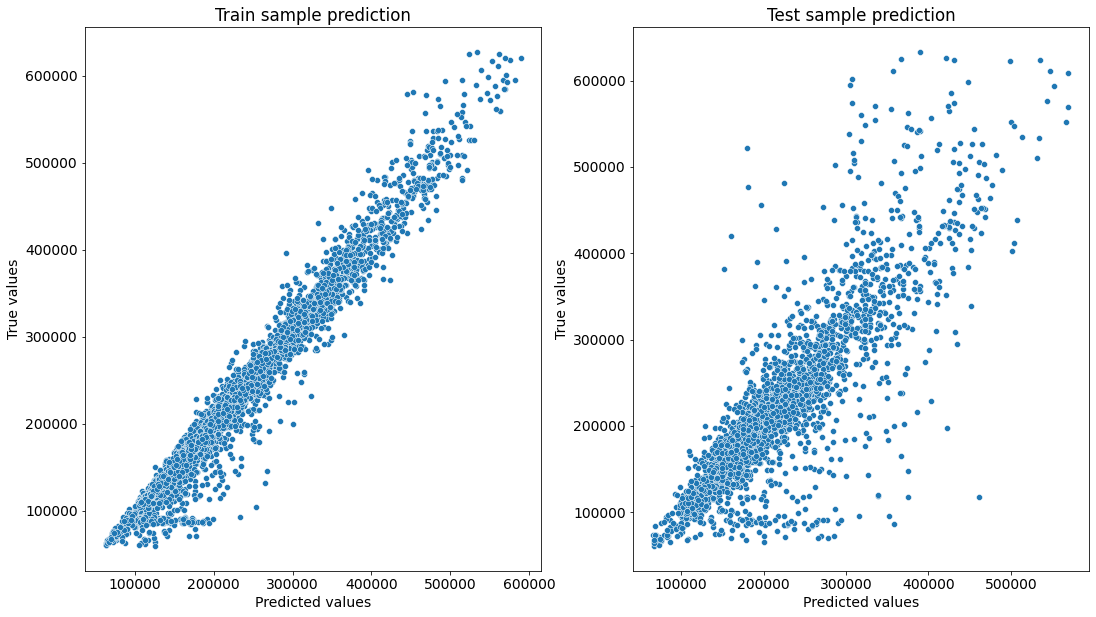

In [1341]:
X_train, X_valid, y_train, y_valid = train_test_split(train_preprocessed, target, test_size=0.3, random_state=42)

scaler = StandardScaler()

colnames = train_preprocessed.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=colnames)
model=RandomForestRegressor()
model.fit(X_train_scaled, y_train)
y_train_pred=model.predict(X_train_scaled)
y_pred = model.predict(X_valid_scaled)

evaluate_preds(y_train,y_train_pred, y_valid, y_pred)


In [1342]:
X_test=pd.read_csv('test.csv')
X_test=fg.add_med_target_by_features(X_test,['DistrictId','Rooms'],'med_price_by_district')
X_preprocessed=dp.transform(X_test)
X_preprocessed.describe()
X_test_scaled=pd.DataFrame(scaler.transform(X_preprocessed), columns=colnames)
y_test = model.predict(X_test_scaled)
X_test['Price']=y_test
result=X_test[['Id','Price']].sort_values('Id')
result.to_csv('lr_result.csv',index = False)


In [1343]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
13,med_price_by_district,0.640723
1,Square,0.054761
2,LifeSquare,0.053784
6,HouseYear,0.037335
3,KitchenSquare,0.033069
5,HouseFloor,0.023067
25,DistrictId_Size,0.021162
23,Healthcare_1,0.018313
9,Social_2,0.017191
7,Ecology_1,0.015670


In [1344]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', model)], final_estimator=gb)
stack.fit(X_train_scaled, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor())],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.886
Test R2:	0.736


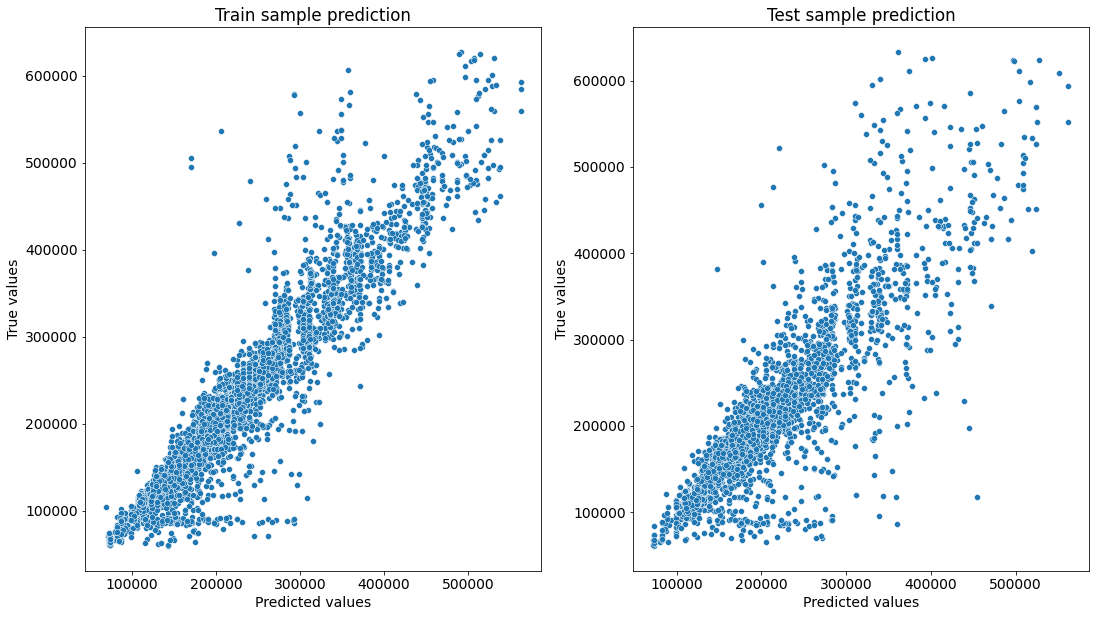

In [1345]:
y_train_preds = stack.predict(X_train_scaled)
y_test_preds = stack.predict(X_valid_scaled)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [1346]:
X_test=pd.read_csv('test.csv')
y_test_pred=stack.predict(X_test_scaled)
X_test['Price']=y_test_pred
result=X_test[['Id','Price']].sort_values('Id')
result.to_csv('staking_result.csv', index=False)